<a href="https://colab.research.google.com/github/timnaruto/image_-Comparison-Siamese/blob/main/image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This project we are going to use triple loss effect to make sure our model knows similariry between two images. One will be positive, negative and then anchor image

In [8]:
## Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from tensorflow.keras.applications import ResNet50


target_shape = (200, 200)

### Load the dataset
* We are going to load the Totally Looks Like dataset and unzip it inside the ~/.keras directory in the local environment.
    - left.zip contains the images that we will use as the anchor.
    - right.zip contains the images that we will use as the positive sample (an image that looks like the anchor).

In [9]:
cache_dir = Path.home() / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [10]:

# Download and extract
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=404af8a1-f59f-4e59-8800-91874f3d1ba4
To: /content/left.zip
100% 104M/104M [00:00<00:00, 131MB/s] 
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=5a181250-f0c0-438c-8216-15a9cfdd1e39
To: /content/right.zip
100% 104

## Preparing the data
* We are going to use a tf.data pipeline to load the data and generate the triplets that we need to train the Siamese network.

* We'll set up the pipeline using a zipped list with anchor, positive, and negative filenames as the source. The pipeline will load and preprocess the corresponding images.


In [11]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

## Data Pipeline
* Let's setup our data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [12]:
# Load and sort images to match pairs correctly
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path) if f.endswith(('.jpg', '.png'))]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path) if f.endswith(('.jpg', '.png'))]
)

image_count = len(anchor_images)

# Convert to TensorFlow datasets
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# Shuffle images using a single RandomState instance
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
rng.shuffle(negative_images)  # Using the same rng instance

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

# Combine datasets
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024).map(preprocess_triplets)

# Split into training and validation sets
train_size = round(image_count * 0.8)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch and prefetch
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Displaying
* Let's take a look at a few examples of triplets. Notice how the first two images look alike while the third one is always different.

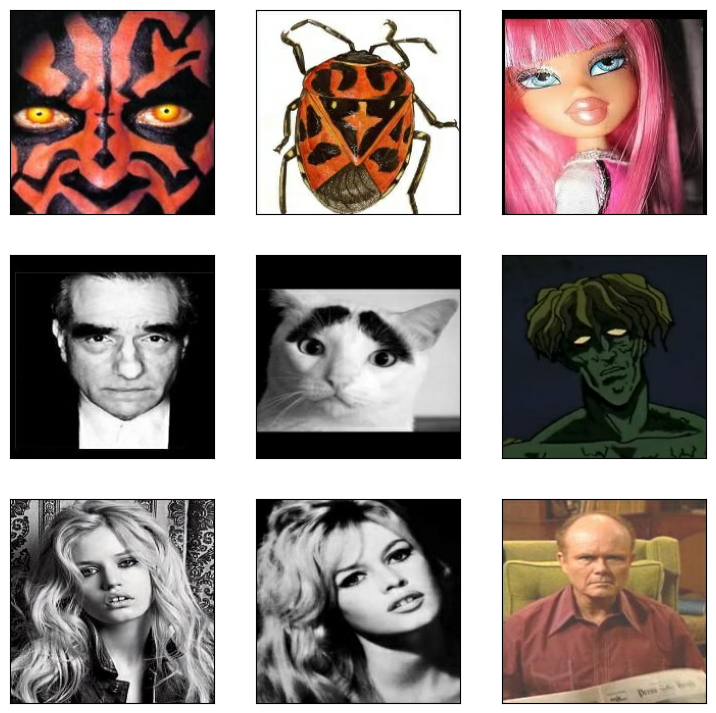

In [13]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Setting up the embedding generator model
Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer conv5_block1_out. This is important to avoid affecting the weights that the model has already learned. We are going to leave the bottom few layers trainable, so that we can fine-tune their weights during training.

In [14]:
# Load Pretrained ResNet50 (without the fully connected layer)
base_cnn = ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

# Global Average Pooling instead of Flatten
gap = layers.GlobalAveragePooling2D()(base_cnn.output)

# Fully Connected Layers
dense1 = layers.Dense(512, activation="relu")(gap)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)

# L2 Normalized Embedding
output = layers.Dense(256, activation=None)(dense2)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="L2_Norm")(output)

# Define Embedding Model
embedding = Model(base_cnn.input, output, name="Embedding")

# Freeze only the first few layers
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        break
    layer.trainable = False

# Summary
embedding.summary()


Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 206, 206, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 50, 50, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 50, 50, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 50, 50, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,836,992 (94.75 MB)

 Trainable params: 10,179,072 (38.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

## Setting up the Siamese Network model
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

In [15]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    Computes the squared Euclidean distance between embeddings.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        # Compute squared Euclidean distances
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return ap_distance, an_distance

# Define Inputs
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# Process Inputs with ResNet Preprocessing
anchor_embedding = embedding(resnet.preprocess_input(anchor_input))
positive_embedding = embedding(resnet.preprocess_input(positive_input))
negative_embedding = embedding(resnet.preprocess_input(negative_input))

# Compute Distances
distances = DistanceLayer()(anchor_embedding, positive_embedding, negative_embedding)

# Define Siamese Model
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

# Summary of Model
siamese_network.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 200, 200, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 200, 200, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 24,836,992 (94.75 MB)

 Trainable params: 10,179,072 (38.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

### Putting everything together
We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

Let's create a Mean metric instance to track the loss of the training process.

In [16]:


class SiameseModel(Model):
    """
    Siamese Network Model with a custom training loop.

    Uses the triplet loss function:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")  # Tracks average loss

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        return {"loss": self.loss_tracker.result()}  # Return tracked loss

    def test_step(self, data):
        loss = self._compute_loss(data)
        return {"loss": self.loss_tracker.result()}  # Return tracked loss

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        # Compute Triplet Loss (Squared Euclidean Distance)
        loss = tf.maximum(tf.square(ap_distance) - tf.square(an_distance) + self.margin, 0.0)

        # Track average loss over the batch
        loss = tf.reduce_mean(loss)
        self.loss_tracker.update_state(loss)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]  # Automatically resets state


## Training


In [19]:

# Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=tf.constant(0.0001, dtype=tf.float32),
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Triplet Loss Function
def triplet_loss(y_true, y_pred, margin=0.2):
    # Unstack y_pred into anchor, positive, and negative embeddings
    anchor, positive, negative = tf.unstack(y_pred, axis=1)

    # Compute squared Euclidean distances
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

    # Compute Triplet Loss with ReLU for numerical stability
    loss = tf.nn.relu(pos_dist - neg_dist + margin)

    return tf.reduce_mean(loss)


In [20]:
siamese_model = SiameseModel(siamese_network)

# Compile with proper metrics
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=triplet_loss,
    metrics=[tf.keras.metrics.Mean(name="triplet_loss")]
)

# Fit model with improved training strategy
history = siamese_model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    steps_per_epoch=len(train_dataset) // 32,
    validation_steps=len(val_dataset) // 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - loss: 0.5002 - val_loss: 0.4994
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 0.4986 - val_loss: 0.5055
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 0.4969 - val_loss: 0.4940
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.4802 - val_loss: 0.4566
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.5090 - val_loss: 0.4960
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.4839 - val_loss: 0.4958
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.5245 - val_loss: 0.4864


In [25]:
# Get a batch from the dataset (it contains triplets: anchor, positive, negative)
sample_batch = next(iter(train_dataset))

# Unpack anchor, positive, and negative images
anchor, positive, negative = sample_batch

# Preprocess the images
anchor_preprocessed = resnet.preprocess_input(anchor)
positive_preprocessed = resnet.preprocess_input(positive)

# Convert symbolic tensors into real NumPy arrays (Eager execution)
anchor_emb = embedding.predict(anchor_preprocessed)
positive_emb = embedding.predict(positive_preprocessed)

# Compute cosine similarity
cosine_similarity = tf.keras.metrics.CosineSimilarity()
positive_similarity = cosine_similarity(anchor_emb, positive_emb)

print("Positive similarity:", positive_similarity.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Positive similarity: 0.9560154


In [ ]:
siamese_model.save('image_similaruty.h5')

In [ ]:
!mv image_similaruty.h5 image_similarity.h5

In [ ]:
!ls

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format keras image_similarity.h5 tfjs_model